# 1 - Imports

In [1]:
from bs4 import BeautifulSoup as bts
from datetime import datetime

import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:.2f}'.format)

# 2 - Helper Functions

## 2.1 - Data processing

In [2]:
def describe(data):
    
    num_attributes = data.select_dtypes( include=['int64', 'float64'] )
    media = pd.DataFrame( num_attributes.apply( np.mean ) )
    mediana = pd.DataFrame( num_attributes.apply( np.median ) )
    std = pd.DataFrame( num_attributes.apply( np.std ) )

    max_ = pd.DataFrame( num_attributes.apply( np.max ) ) 
    min_ = pd.DataFrame( num_attributes.apply( np.min ) ) 

    df_sc = pd.concat([max_, min_, media, mediana, std], axis=1 ).reset_index()
    df_sc.columns = ['attributes', 'max', 'min', 'mean', 'median', 'std']
    
    return df_sc





###################################################################
#                     Data Processing H&M
###################################################################

def dp_hm (path):
    
    data = pd.read_csv(path, sep=';')
    
    
    # Removendo dados duplicados
    
    data = data.drop_duplicates()
    
    
    # Removendo dados nulos/faltantes das principais colunas
    
    data = data.dropna(subset=['product_id', 'product_name', 'product_price', 'product_composition', 'product_fit'])
        
    
    # Removendo dados fora de contexto das principais colunas
    
    data = data.loc[~((data['product_fit'] == """The model is 189cm/6'2" and wears a size 31/32""") |
                     (data['product_fit'] == """The model is 187cm/6'2" and wears a size 31/32""")),:]
    
    data = data.reset_index(drop=True)
    
    return data



def column_hm(data):

    data['product_id'] = data['product_id'].astype('int64').astype('str')
    
    data['data_scrapy'] = data['data_scrapy'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M"))
    data['data_year'] = data['data_scrapy'].apply(lambda x: x.year)
    data['data_month'] = data['data_scrapy'].apply(lambda x: datetime.strptime(str(x.month), '%m').strftime('%b'))
    data['data_day_name'] = data['data_scrapy'].apply(lambda x: datetime.strptime(str(x.day), '%d').strftime('%A'))
    data['data_day_number'] = data['data_scrapy'].apply(lambda x: x.day)
    
    data['product_price'] = data['product_price'].astype('float64')
    data['product_price_new'] = data['product_price_new'].astype('float64')
    
    return data


###################################################################
#                     Data Processing Macy's
###################################################################

def dp_macys (path2):
    
    data = pd.read_csv(path2)
    
    # Removendo dados duplicados
    
    data = data.drop_duplicates()
    
        
    # Extraindo o estilo da calça de 'product_ref'
    
    data['product_fit'] = data['product_ref'].apply(lambda x: 'Straight Jeans' if 'Straight' in x  else
                                                              'Straight Jeans' if 'Regular'  in x  else
                                                              'Bootcut Jeans'  if 'Bootcut'  in x  else
                                                              'Relaxed Jeans'  if 'Relaxed'  in x  else
                                                              'Skinny Jeans'   if 'Skinny'   in x  else
                                                              'Slim Jeans'     if 'Slim'     in x  else
                                                              'Baggy Jeans'    if 'Baggy'    in x  else
                                                              'Athletic Jeans' if 'Athletic' in x  else 
                                                              'Modern Jeans')
    
    return data



def column_macys(data):

    data['product_id'] = data['product_id'].astype('str')
    
    data['data_scrapy'] = data['data_scrapy'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    data['data_year'] = data['data_scrapy'].apply(lambda x: x.year)
    data['data_month'] = data['data_scrapy'].apply(lambda x: datetime.strptime(str(x.month), '%m').strftime('%b'))
    data['data_day_name'] = data['data_scrapy'].apply(lambda x: datetime.strptime(str(x.day), '%d').strftime('%A'))
    data['data_day_number'] = data['data_scrapy'].apply(lambda x: x.day)
    
    data['product_price'] = data['product_price'].astype('float64')
    data['product_sale'] = data['product_sale'].astype('float64')
    
    return data

## 2.2 - Regular expression

In [3]:
###################################################################
#                         Regex H&M
###################################################################

def regex_hm(data):
    
    # Extraindo informações da coluna 'product_composition'
    
    y = []
    
    regex = 'Shell:\s(.+%)[A-Z]|Shell:\s(.+%)'
    regex2 = 'Composition([Cotton].+%)[A-Z]|%([Cotton].+%)'
    regex3 = 'Composition([Cotton].+%)|%([Cotton].+%)'
        
    for i in range(len(data)):
        
        if "Shell" in data.loc[i, 'product_composition']:
            if re.search(regex, data.loc[i, 'product_composition']).group(2) == None:
                y.append(re.search(regex, data.loc[i, 'product_composition']).group(1))

            else:
                y.append(re.search(regex, data.loc[i, 'product_composition']).group(2))

        elif "Pocket" in data.loc[i, 'product_composition']:
            if re.search(regex2, data.loc[i, 'product_composition']).group(2) == None:
                y.append(re.search(regex2, data.loc[i, 'product_composition']).group(1))

            else:
                y.append(re.search(regex2, data.loc[i, 'product_composition']).group(2))
        
        elif "Lining" in data.loc[i, 'product_composition']:
            if re.search(regex2, data.loc[i, 'product_composition']).group(2) == None:
                y.append(re.search(regex2, data.loc[i, 'product_composition']).group(1))

            else:
                y.append(re.search(regex2, data.loc[i, 'product_composition']).group(2))
                
        else:
            if re.search(regex3, data.loc[i, 'product_composition']).group(2) == None:
                y.append(re.search(regex3, data.loc[i, 'product_composition']).group(1))

            else:
                y.append(re.search(regex3, data.loc[i, 'product_composition']).group(2))
        
    data1 = pd.DataFrame([y]).T
    data1.columns = ['product_composition']
    data1 = data1['product_composition'].str.split(',', expand=True)
    
    data_ref = pd.DataFrame(index=np.arange(len(data)) ,columns=['cotton', 'spandex', 'polyester', 'elastomultiester'])
    
    df_cotton = data1[0]
    df_cotton.name = 'cotton'
    data_ref = pd.concat([data_ref, df_cotton], axis=1)
    data_ref = data_ref.iloc[:, ~data_ref.columns.duplicated(keep='last')]
    
    
    df_spandex = data1.loc[data1[1].str.contains('Spandex', na=True),1]
    df_spandex.name = 'spandex'
    df_spandex = df_spandex.combine_first(data1[2])
    data_ref = pd.concat([data_ref, df_spandex], axis=1)
    data_ref = data_ref.iloc[:, ~data_ref.columns.duplicated(keep='last')] 
    data_ref['spandex'] = data_ref['spandex'].fillna('Spandex 0%')

    
    df_polyester = data1.loc[data1[1].str.contains('Polyester', na=True),1]
    df_polyester.name = 'polyester'
    data_ref = pd.concat([data_ref, df_polyester], axis=1)
    data_ref = data_ref.iloc[:, ~data_ref.columns.duplicated(keep='last')] 
    data_ref['polyester'] = data_ref['polyester'].fillna('Polyester 0%')

    
    df_elasto = data1.loc[data1[1].str.contains('Elastomultiester', na=True), 1]
    df_elasto.name = 'elastomultiester'

    data_ref = pd.concat([data_ref, df_elasto], axis=1)
    data_ref = data_ref.iloc[:, ~data_ref.columns.duplicated(keep='last')] 
    data_ref['elastomultiester'] = data_ref['elastomultiester'].fillna('Elastomultiester 0%')
    
    
    data = pd.concat([data, data_ref], axis=1)

    data['cotton'] = data['cotton'].apply(lambda x: int(re.search('\d+', x).group(0))/100)
    data['spandex'] = data['spandex'].apply(lambda x: int(re.search('\d+', x).group(0))/100)
    data['polyester'] = data['polyester'].apply(lambda x: int(re.search('\d+', x).group(0))/100)
    data['elastomultiester'] = data['elastomultiester'].apply(lambda x: int(re.search('\d+', x).group(0))/100)

    
    # Extraindo o preço das colunas 'product_price' e 'product_price_new'
    
    data['product_price'] = data['product_price'].apply(lambda x: re.search('\w.+', x).group(0))
    data['product_price_new'] = data['product_price_new'].apply(lambda x: re.search('\w.+', x).group(0) if pd.notnull(x) else x)
    data['product_price_new'] = data['product_price_new'].fillna(0)
    
    return data




###################################################################
#                         Regex Macy's
###################################################################

def regex_macys(data):
    
    # Extraindo os preços de venda e de promoção de 'product_price'
    
    regex = '.(\d+\.\d+)'
    regex2 = 'Sale..(\d+\.\d+)'
    
    
    data['product_sale'] = data['product_price'].apply(lambda x: re.search(regex2, x).group(1) if "Sale" in x else 0)
    data['product_price'] = data['product_price'].apply(lambda x: re.search(regex, x).group(1))
    
    data['product_sale'] = data['product_sale'].fillna(0)
    
    
    return data


## 2.3 - Plotting

In [4]:
def data_hist(data, x):
    
    sns.set_theme()
    fig, ax = plt.subplots(figsize=(8,6))
    sns.histplot(data=data, x=x, ax=ax)
    
    return None

# 3 - Web Scraping

Todas as extrações foram realizadas durante o mesmo período de doze dias.

## 3.1 - Web scraping H&M

A extração dos dados do site da H&M foi realizado com a biblioteca Selenium, sendo executado na IDE PyCharm. O arquivo ".py" pode ser encontrado no repositório.

## 3.2 - Web scraping Macy's

In [ ]:
url = 'https://www.macys.com/shop/mens-clothing/mens-jeans/Productsperpage/120?id=11221'

headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36'}

page = requests.get(url, headers=headers)

soup = bts(page.text, 'html.parser')

# Passo 1: Items da primeira página

    ##################################
    # Product id
    ##################################

    vitrine = soup.find('ul', class_='items grid-x small-up-2 medium-up-3 large-up-3')
    vitrine_items = vitrine.find_all('div', class_='productThumbnail redesignEnabled')
    product_id = [i.get('id') for i in vitrine_items]


    ##################################
    # Product name
    ##################################

    vitrine_name = vitrine.find_all('div', class_='productBrand')
    product_name = [i.get_text().strip() for i in vitrine_name]


    ##################################
    # Product reference
    ##################################

    vitrine_ref = vitrine.find_all('a', class_='productDescLink')
    product_ref = []

    for i in range(0, len(vitrine_ref), 2):

        product_ref.append(vitrine_ref[i].get('title'))


    ##################################
    # Product price
    ##################################

    vitrine_price = vitrine.find_all('div', class_='prices')
    product_price = [i.get_text().strip() for i in vitrine_price]


    
# Passo 2: Extraindo os dados de todas as páginas

    ##################################
    # Pagination
    ##################################

    j = soup.find('div', class_='cell small-12')
    k = j.find_all('option')


    for i in range(2, (len(k)+1)):

        url2 = 'https://www.macys.com/shop/mens-clothing/mens-jeans/Pageindex,Productsperpage/' + str(i) + ',120?id=11221'

        page2 = requests.get(url2, headers=headers)

        soup2 = bts(page2.text, 'html.parser')

        ##################################
        # Product id
        ##################################

        vitrine2 = soup2.find('ul', class_='items grid-x small-up-2 medium-up-3 large-up-3')
        vitrine_items2 = vitrine2.find_all('div', class_='productThumbnail redesignEnabled')
        product_id2 = [i.get('id') for i in vitrine_items2]

        product_id = [*product_id, *product_id2]


        ##################################
        # Product name
        ##################################

        vitrine_name2 = vitrine2.find_all('div', class_='productBrand')
        product_name2 = [i.get_text().strip() for i in vitrine_name2]

        product_name = [*product_name, *product_name2]


        ##################################
        # Product reference
        ##################################

        vitrine_ref2 = vitrine2.find_all('a', class_='productDescLink')
        product_ref2 = []

        for j in range(0, len(vitrine_ref2), 2):

            product_ref2.append(vitrine_ref2[j].get('title'))

        product_ref = [*product_ref, *product_ref2]

        ##################################
        # Product price
        ##################################

        vitrine_price2 = vitrine2.find_all('div', class_='prices')
        product_price2 = [i.get_text().strip() for i in vitrine_price2]

        product_price = [*product_price, *product_price2]

    

# Passo 3: Salvando os dados

data1 = pd.DataFrame([product_id, product_name, product_ref, product_price]).T
data1.columns = ['product_id', 'product_name', 'product_ref', 'product_price']
data1['data_scrapy'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

data = pd.read_csv('data.csv')

data_macys = pd.concat([data1, data], axis=0, ignore_index=True)

data_macys.to_csv('data.csv', index=False)

# 4 - Data Processing

## 4.1 - Processing H&M

### 4.1.1 - Dataframe

In [5]:
# Passo 1: Carregando os dados
data_hm = dp_hm('data_h&m.csv')


# Passo 2: Aplicando regex para tratar os dados
data_hm = regex_hm(data_hm)


# Passo 3: Modificando o tipo dos dados
data_hm = column_hm(data_hm)

data_hm.head()

,product_id,product_name,product_price,product_price_new,product_color,product_fit,product_size,product_materials,product_composition,data_scrapy,cotton,spandex,polyester,elastomultiester,data_year,data_month,data_day_name,data_day_number
0,1024256001,Slim Jeans,29.99,0.00,Black,Slim fit,"The model is 185cm/6'1"" and wears a size 31/32",Lining: Recycled cotton 20%,"CompositionPocket lining: Polyester 65%, Cotto...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12
1,1024256002,Slim Jeans,29.99,0.00,Light denim blue,Slim fit,"The model is 189cm/6'2"" and wears a size 31/32","Lining: Recycled polyester 65%, Recycled cotto...","CompositionShell: Cotton 99%, Spandex 1%Pocket...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12
2,1024256003,Slim Jeans,29.99,0.00,Light denim blue,Slim fit,"The model is 189cm/6'2"" and wears a size 31/32",Shell: Recycled cotton 20%,"CompositionShell: Cotton 99%, Spandex 1%Pocket...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12
3,1024256004,Slim Jeans,29.99,0.00,Denim blue,Slim fit,NaN,"Lining: Recycled polyester 65%, Recycled cotto...","CompositionShell: Cotton 99%, Spandex 1%Pocket...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12
4,1024256005,Slim Jeans,29.99,0.00,Dark blue,Slim fit,"The model is 180cm/5'11"" and wears a size 31/32",Shell: Recycled cotton 20%,"CompositionPocket lining: Polyester 65%, Cotto...",2022-04-12 13:40:00,0.99,0.01,0.00,0.00,2022,Apr,Friday,12


### 4.1.2 - Columns

In [58]:
data_hm.columns

Index(['product_id', 'product_name', 'product_price', 'product_price_new',
       'product_color', 'product_fit', 'product_size', 'product_materials',
       'product_composition', 'data_scrapy', 'cotton', 'spandex', 'polyester',
       'elastomultiester', 'data_year', 'data_month', 'data_day_name',
       'data_day_number'],
      dtype='object')

Descrição:

- product_id: Código de cada item para venda
- product_name: Nome do produto
- product_price: Preço do produto
- product_price_new: Preço de promoção do produto 
- product_color: Cor da calça
- product_fit: Estilo da calça jeans
- product_size: Tamanho do produto
- product_materials: Tipo de material que compõe o produto
- product_composition: Composição do produto
- data_scrapy: Data da extração de dados
- cotton: Porcentagem de algodão no produto
- spandex: Porcentagem de spandex no produto
- polyester: Porcentagem de polyester no produto
- elastomultiester: Porcentagem de elastomultiester no produto
- data_year: Ano da extração de dados
- data_month: Mês da extração de dados
- data_day_name: Dia da semana em que foi extraido os dados
- data_day_number: Dia da extração extração de dados

### 4.1.3 - Data dimension

In [59]:
print(f'A quantidade de linhas do dataframe é: {data_hm.shape[0]}')
print(f'A quantidade de colunas do dataframe é: {data_hm.shape[1]}')

A quantidade de linhas do dataframe é: 2380
A quantidade de colunas do dataframe é: 18


### 4.1.4 - Data types

In [20]:
data_hm.dtypes

product_id                     object
product_name                   object
product_price                 float64
product_price_new             float64
product_color                  object
product_fit                    object
product_size                   object
product_materials              object
product_composition            object
data_scrapy            datetime64[ns]
cotton                        float64
spandex                       float64
polyester                     float64
elastomultiester              float64
data_year                       int64
data_month                     object
data_day_name                  object
data_day_number                 int64
dtype: object

## 4.2 - Processing Macy's

### 4.2.1 - Dataframe

In [6]:
# Passo 1: Carregando os dados

data_macys = dp_macys('data_macys.csv')


# Passo 2: Aplicando regex para tratar os dados
data_macys = regex_macys(data_macys)


# Passo 3: Modificando o tipo dos dados
data_macys = column_macys(data_macys)

data_macys.head()

,product_id,product_name,product_ref,product_price,data_scrapy,product_fit,product_sale,data_year,data_month,data_day_name,data_day_number
0,1654744,Polo Ralph Lauren,Men's Hampton Relaxed Straight Jeans,98.50,2022-04-16 18:13:16,Straight Jeans,0.00,2022,Apr,Tuesday,16
1,1103208,Levi's,Men's 511™ Slim Fit Jeans,69.50,2022-04-16 18:13:16,Slim Jeans,59.99,2022,Apr,Tuesday,16
2,9617175,Levi's,Levi’s® Flex Men's 514™ Straight-Fit Jeans,69.50,2022-04-16 18:13:16,Straight Jeans,59.99,2022,Apr,Tuesday,16
3,6545489,Calvin Klein,Men's Slim-Fit Jeans,79.50,2022-04-16 18:13:16,Slim Jeans,0.00,2022,Apr,Tuesday,16
4,2834394,Levi's,Men's 502™ Taper Jeans,69.50,2022-04-16 18:13:16,Modern Jeans,59.99,2022,Apr,Tuesday,16


### 4.2.2 - Columns

In [75]:
data_macys.columns

Index(['product_id', 'product_name', 'product_ref', 'product_price',
       'data_scrapy', 'product_fit', 'product_sale', 'data_year', 'data_month',
       'data_day_name', 'data_day_number'],
      dtype='object')

Descrição:

- product_id: Código de cada item para venda
- product_name: Nome do produto/marca
- product_ref: Referência do produto
- product_price: Preço do produto
- data_scrapy: Data da extração de dados
- product_fit: Estilo da calça jeans
- product_sale: Preço de promoção do produto
- data_year: Ano da extração de dados
- data_month: Mês da extração de dados
- data_day_name: Dia da semana em que foi extraido os dados
- data_day_number: Dia da extração extração de dados

### 4.2.3 - Data dimension

In [76]:
print(f'A quantidade de linhas do dataframe é: {data_macys.shape[0]}')
print(f'A quantidade de colunas do dataframe é: {data_macys.shape[1]}')

A quantidade de linhas do dataframe é: 8942
A quantidade de colunas do dataframe é: 11


### 4.2.4 - Data types

In [77]:
data_macys.dtypes

product_id                 object
product_name               object
product_ref                object
product_price             float64
data_scrapy        datetime64[ns]
product_fit                object
product_sale              float64
data_year                   int64
data_month                 object
data_day_name              object
data_day_number             int64
dtype: object

# 5 - EDA

## 5.1 - Describe

### 5.1.1 - Describe H&M

In [8]:
describe(data_hm)

,attributes,max,min,mean,median,std
0,product_price,119.99,11.99,44.62,39.99,25.62
1,product_price_new,39.99,0.00,2.82,0.00,7.96
2,cotton,1.00,0.77,0.97,0.99,0.06
3,spandex,0.02,0.00,0.01,0.01,0.01
4,polyester,0.21,0.00,0.02,0.00,0.06
5,elastomultiester,0.09,0.00,0.00,0.00,0.02
6,data_year,2022.00,2022.00,2022.00,2022.00,0.00
7,data_day_number,13.00,2.00,8.38,9.00,3.07


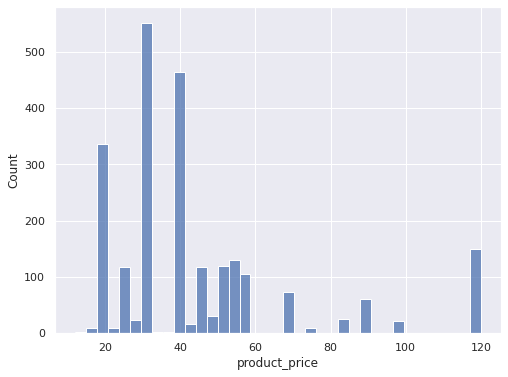

In [7]:
data_hist(data_hm, 'product_price')

Algumas considerações:

- O atributo 'product_price' representa o preço de venda normal dos items; é possível observar que o maior preço encontrado é de 119,99 dólares e o menor valor sendo 11,99 dólares;
- A média dos preços está em torno de 44,62 dólares, fazendo inferir que grande parte dos produtos possuem valores menores que o valor máximo;
- A mediana é a forma mais fiel para expressar a distribuição dos preços nessa situação em que não há uma distribuição normal, como observado no histograma acima. O valor mediano dos preços é de 39,99 dólares;
- No atributo 'product_price_new' representa os preços de promoção das calças. Os produtos com valor zero nesse atributo, significa que não teve preço de promoção. O maior valor encontrado foi de 39,99 dólares;
- As composições das calças estão representadas desde 'cotton' até 'elastomultiester'.

### 5.1.2 - Describe Macy's

In [9]:
describe(data_macys)

,attributes,max,min,mean,median,std
0,product_price,348.00,29.50,102.63,89.00,49.31
1,product_sale,167.30,0.00,15.84,0.00,29.28
2,data_year,2022.00,2022.00,2022.00,2022.00,0.00
3,data_day_number,16.00,2.00,8.92,9.00,4.34


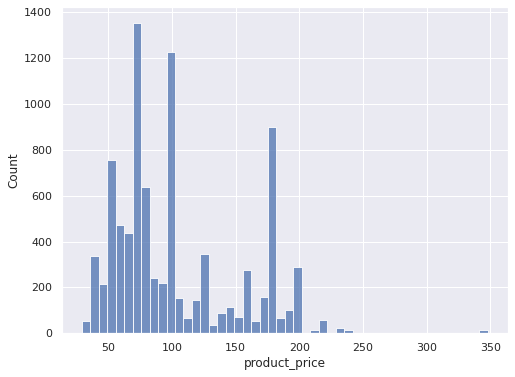

In [10]:
data_hist(data_macys, 'product_price')

In [ ]:
Algumas considerações:

- O atributo 'product_price' representa o preço de venda normal dos items; é possível observar que o maior preço encontrado é de 119,99 dólares e o menor valor sendo 11,99 dólares;
- A média dos preços está em torno de 44,62 dólares, fazendo inferir que grande parte dos produtos possuem valores menores que o valor máximo;
- A mediana é a forma mais fiel para expressar a distribuição dos preços nessa situação em que não há uma distribuição normal, como observado no histograma acima. O valor mediano dos preços é de 39,99 dólares;
- No atributo 'product_price_new' representa os preços de promoção das calças. Os produtos com valor zero nesse atributo, significa que não teve preço de promoção. O maior valor encontrado foi de 39,99 dólares;
- As composições das calças estão representadas desde 'cotton' até 'elastomultiester'.

### 5.1.3 - Comparation

# 6 - Business case

# 7 - Conclusion and Next Steps